In [1]:
import matplotlib.pyplot as plt
import pymongo
import numpy as np
import pandas as pd
import json
import re
import ast
import seaborn as sns
import matplotlib.dates as mdates
import itertools
#sns.set_style("white")

In [2]:
from collections import OrderedDict

In [3]:
df = pd.read_csv('DATA_CRAN/CRAN_DATA_20191231.csv', sep='|', low_memory=False)
df.shape

(91321, 39)

In [4]:
df['DatePublication'] = pd.to_datetime(df['Date/Publication'], utc=True).values.astype('M8[D]')

In [5]:
columns = ['Imports','Depends','Suggests','LinkingTo']
for col in columns:
    df[[col]] = df[[col]].applymap(lambda x: ast.literal_eval(x))

In [6]:
# Transforma columna a una lista
df[['Author']] = df[['Author']].applymap(lambda x: [x] if not isinstance(x, list) else x)

# Elimina los valores [nan]
df[['Author']] = df[['Author']].applymap(lambda x: [] if str(x) == "[nan]" else x)

In [7]:
df[['Author', 'Maintainer']].sample(5)

,Author,Maintainer
13578,"[Jim Lemon <jim@bitwrit.com.au>,]",Jim Lemon <jim@bitwrit.com.au>
5799,[Michael J. Kane <kaneplusplus@gmail.com> and ...,Michael J. Kane <bigmemoryauthors@gmail.com>
54997,"[Peter Filzmoser, Heinrich Fritz, Klaudius Kal...",Heinrich Fritz <Heinrich_Fritz@hotmail.com>
48981,"[Walter R. Mebane, Jr. <wrm1@cornell.edu>, Jas...",Jasjeet Singh Sekhon <sekhon@berkeley.edu>
14814,"[Christopher Gandrud [aut, cre]]",Christopher Gandrud <christopher.gandrud@gmail...


In [8]:
df[['Maintainer']]

,Maintainer
0,Scott Fortmann-Roe <scottfr@berkeley.edu>
1,Scott Fortmann-Roe <scottfr@berkeley.edu>
2,Scott Fortmann-Roe <scottfr@berkeley.edu>
3,Raja Sekhara Reddy D.M <raja.duvvuru@gmail.com>
4,Raja Sekhara Reddy D.M <raja.duvvuru@gmail.com>
...,...
91316,Leah F. South <leah.south@hdr.qut.edu.au>
91317,David Bronaugh <bronaugh@uvic.ca>
91318,David Bronaugh <bronaugh@uvic.ca>
91319,David Bronaugh <bronaugh@uvic.ca>


# Construcción grafo

In [9]:
df_lv = df.dropna(subset=['DatePublication']).copy()
df_lv.set_index(["Package"], inplace=True)
df_lv.sort_values('DatePublication', ascending=False, inplace=True)

In [10]:
df_lv.shape

(91321, 38)

In [11]:
df_ADJ = df_lv[['Version','Imports','Depends','LinkingTo', 'Year_Month/Publication']]
df_ADJ.head()

,Version,Imports,Depends,LinkingTo,Year_Month/Publication
Package,,,,,
slurmR,0.3-0,[utils],"[R, parallel]",[],2019-12
workflows,0.1.0,"[cli, ellipsis, generics, glue, hardhat, parsn...",[R],[],2019-12
multilinguer,0.0.3,"[sys, fs, usethis, zip, askpass, xml2, rvest, ...",[],[],2019-12
sbw,1.0,"[MASS, spatstat]","[R, Matrix, quadprog, slam]",[],2019-12
uavRst,0.5-4,"[raster, foreach]",[R],[Rcpp],2019-12


In [12]:
df_ADJ[df_ADJ.index.isin(['Matrix'])]

,Version,Imports,Depends,LinkingTo,Year_Month/Publication
Package,,,,,
Matrix,1.2-18,"[methods, graphics, grid, stats, utils, lattice]",[R],[],2019-11
Matrix,1.2-17,"[methods, graphics, grid, stats, utils, lattice]",[R],[],2019-03
Matrix,1.2-16,"[methods, graphics, grid, stats, utils, lattice]",[R],[],2019-03
Matrix,1.2-15,"[methods, graphics, grid, stats, utils, lattice]",[R],[],2018-11
Matrix,1.2-14,"[methods, graphics, grid, stats, utils, lattice]",[R],[],2018-04
...,...,...,...,...,...
Matrix,0.3-5,[],[R],[],2000-08
Matrix,0.3-3,[],[R],[],2000-08
Matrix,0.3-1,[],[R],[],2000-07


In [14]:
def values_uniques(df):
    return np.unique(list(row.strip() for cols in df for row in cols))

df_ADJ['all'] = df_ADJ[['Imports', 'Depends', 'LinkingTo'][0:2]].apply(values_uniques, axis=1)
df_ADJ.head()

/home/mmora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Version,Imports,Depends,LinkingTo,Year_Month/Publication,all
Package,,,,,,
slurmR,0.3-0,[utils],"[R, parallel]",[],2019-12,"[R, parallel, utils]"
workflows,0.1.0,"[cli, ellipsis, generics, glue, hardhat, parsn...",[R],[],2019-12,"[R, cli, ellipsis, generics, glue, hardhat, pa..."
multilinguer,0.0.3,"[sys, fs, usethis, zip, askpass, xml2, rvest, ...",[],[],2019-12,"[askpass, fs, rstudioapi, rvest, sys, usethis,..."
sbw,1.0,"[MASS, spatstat]","[R, Matrix, quadprog, slam]",[],2019-12,"[MASS, Matrix, R, quadprog, slam, spatstat]"
uavRst,0.5-4,"[raster, foreach]",[R],[Rcpp],2019-12,"[R, foreach, raster]"


In [26]:
df_ADJ.loc['acc']['all']

Package
acc    [DBI, PhysicalActivity, R, RSQLite, R_utils, R...
acc    [PhysicalActivity, R, methods, mhsmm, nleqslv,...
acc    [PhysicalActivity, R, methods, mhsmm, nleqslv,...
acc                    [PhysicalActivity, R, mhsmm, zoo]
acc          [PhysicalActivity, R, mhsmm, timeDate, zoo]
acc          [PhysicalActivity, R, mhsmm, timeDate, zoo]
Name: all, dtype: object

In [29]:
for package in df_ADJ.loc['acc']['all']:
    for item in package:
            print(item.replace('_', '.'))

DBI
PhysicalActivity
R
RSQLite
R.utils
Rcpp
circlize
ggplot2
iterators
methods
mhsmm
nleqslv
plyr
zoo
PhysicalActivity
R
methods
mhsmm
nleqslv
plyr
zoo
PhysicalActivity
R
methods
mhsmm
nleqslv
plyr
zoo
PhysicalActivity
R
mhsmm
zoo
PhysicalActivity
R
mhsmm
timeDate
zoo
PhysicalActivity
R
mhsmm
timeDate
zoo


# Construcción grafo

In [40]:
df_ADJ['Year_Month/Publication']

Package
slurmR          2019-12
workflows       2019-12
multilinguer    2019-12
sbw             2019-12
uavRst          2019-12
                 ...   
akima           1998-08
tripack         1998-08
mda             1998-04
oz              1998-02
leaps           1997-12
Name: Year_Month/Publication, Length: 91321, dtype: object

In [35]:
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta


def datespan(startDate, endDate, delta=timedelta(days=1)):
    currentDate = startDate
    while currentDate < endDate:
        yield currentDate
        currentDate += delta


In [36]:
meses = []

for day in datespan(date(1999, 1, 1), date(2020, 1, 1),delta=relativedelta(months=1)):
     meses.append(day.strftime('%Y-%m'))

In [54]:
len(meses)

252

In [57]:
# Filtro el df por fecha
df_ADJ[df_ADJ['Year_Month/Publication'] <= meses[251]]

,Version,Imports,Depends,LinkingTo,Year_Month/Publication,all
Package,,,,,,
slurmR,0.3-0,[utils],"[R, parallel]",[],2019-12,"[R, parallel, utils]"
workflows,0.1.0,"[cli, ellipsis, generics, glue, hardhat, parsn...",[R],[],2019-12,"[R, cli, ellipsis, generics, glue, hardhat, pa..."
multilinguer,0.0.3,"[sys, fs, usethis, zip, askpass, xml2, rvest, ...",[],[],2019-12,"[askpass, fs, rstudioapi, rvest, sys, usethis,..."
sbw,1.0,"[MASS, spatstat]","[R, Matrix, quadprog, slam]",[],2019-12,"[MASS, Matrix, R, quadprog, slam, spatstat]"
uavRst,0.5-4,"[raster, foreach]",[R],[Rcpp],2019-12,"[R, foreach, raster]"
...,...,...,...,...,...,...
akima,0.2-3,[],[],[],1998-08,[]
tripack,1.0-1,[],[],[],1998-08,[]
mda,0.1-1,[],[],[],1998-04,[]


In [58]:
df_ADJ[df_ADJ['Year_Month/Publication'] <= meses[251]][df_ADJ[df_ADJ['Year_Month/Publication'] <= meses[251]].index.duplicated()]

,Version,Imports,Depends,LinkingTo,Year_Month/Publication,all
Package,,,,,,
foreign,0.8-73,"[methods, utils, stats]",[R],[],2019-12,"[R, methods, stats, utils]"
TreeTools,0.1.2,"[colorspace, phangorn, R_cache]","[R, ape]",[Rcpp],2019-12,"[R, R_cache, ape, colorspace, phangorn]"
MuMIn,1.43.14,"[graphics, methods, Matrix, stats, stats4, nlme]",[R],[],2019-12,"[Matrix, R, graphics, methods, nlme, stats, st..."
disk.frame,0.3.0,"[Rcpp, glue, rlang, furrr, future_apply, fs, j...","[R, dplyr, purrr]",[Rcpp],2019-12,"[R, Rcpp, bigreadr, bit64, crayon, data_table,..."
seqmagick,0.1.2,"[Biostrings, magrittr, utils]",[R],[],2019-12,"[Biostrings, R, magrittr, utils]"
...,...,...,...,...,...,...
akima,0.2-3,[],[],[],1998-08,[]
tripack,1.0-1,[],[],[],1998-08,[]
mda,0.1-1,[],[],[],1998-04,[]


In [43]:
def last_version_package_by_year(df):
    return df.iloc[[0]]

def cran_mensual(df, fecha):
    df = df[df['Year_Month/Publication'] <= fecha]
    df = df.groupby(level=[0], group_keys=False).apply(last_version_package_by_year)
    df = df.reset_index()
    return df

In [59]:
df_test = cran_mensual(df_ADJ,meses[251])
df_test.shape

(15369, 7)

In [60]:
df_test.head()

,Package,Version,Imports,Depends,LinkingTo,Year_Month/Publication,all
0,A3,1.0.0,[],"[R, xtable, pbapply]",[],2015-08,"[R, pbapply, xtable]"
1,ABACUS,1.0.0,"[ggplot2, shiny]",[R],[],2019-09,"[R, ggplot2, shiny]"
2,ABC.RAP,0.9.0,"[graphics, stats, utils]",[R],[],2016-10,"[R, graphics, stats, utils]"
3,ABCanalysis,1.2.1,[plotrix],[R],[],2017-03,"[R, plotrix]"
4,ABCoptim,0.15.0,"[Rcpp, graphics, stats, utils]",[],[Rcpp],2017-11,"[Rcpp, graphics, stats, utils]"


In [46]:
import networkx as nx

In [47]:
def construir_grafo(df_test):
    DG = nx.DiGraph()

    for index, row in df_test.iterrows():
        DG.add_node(row['Package'].replace('_', '.'))
        for package in row['all']:
            DG.add_edge(row['Package'].replace('_', '.'), package.replace('_', '.'))
            
    return DG

In [61]:
df_test['Package'].values.tolist()

['A3',
 'ABACUS',
 'ABC.RAP',
 'ABCanalysis',
 'ABCoptim',
 'ABCp2',
 'ABHgenotypeR',
 'ABPS',
 'ACA',
 'ACCLMA',
 'ACD',
 'ACDm',
 'ACEt',
 'ACMEeqtl',
 'ACNE',
 'ACSNMineR',
 'ACSWR',
 'ACTCD',
 'ADAPTS',
 'ADCT',
 'ADDT',
 'ADGofTest',
 'ADMM',
 'ADMMnet',
 'ADMMsigma',
 'ADPF',
 'ADPclust',
 'AEDForecasting',
 'AER',
 'AF',
 'AFM',
 'AFheritability',
 'AGD',
 'AGHmatrix',
 'AGSDest',
 'AGread',
 'AHM',
 'AHMbook',
 'AHR',
 'AICcmodavg',
 'AID',
 'AIG',
 'AIM',
 'ALA4R',
 'ALDqr',
 'ALEPlot',
 'ALS',
 'ALSCPC',
 'ALSM',
 'ALTopt',
 'ALassoSurvIC',
 'AMAP.Seq',
 'AMCP',
 'AMCTestmakeR',
 'AMGET',
 'AMIAS',
 'AMModels',
 'AMOEBA',
 'AMORE',
 'AMPLE',
 'AMR',
 'ANN2',
 'ANOM',
 'ANOVA.TFNs',
 'ANOVAIREVA',
 'ANOVAShiny',
 'ANOVAreplication',
 'APCanalysis',
 'APFr',
 'APIS',
 'APML0',
 'APPEstimation',
 'APSIM',
 'APSIMBatch',
 'APfun',
 'APtools',
 'AR',
 'AR1seg',
 'ARCensReg',
 'ARHT',
 'ARIbrain',
 'AROC',
 'ARPobservation',
 'ART',
 'ARTIVA',
 'ARTP',
 'ARTP2',
 'ARTool',
 'ARpLME

In [70]:
lista_completa = []
for index, row in df_test.iterrows():
    for item in row['all']:
        lista_completa.append(item.replace('_', '.'))

In [71]:
todos = list(set(lista_completa))

In [72]:
def returnNotMatches(a, b):
    return [[x for x in a if x not in b], [x for x in b if x not in a]]

In [73]:
fallo = returnNotMatches(todos, df_test['Package'].values.tolist())
len(fallo[0])

148

In [74]:
len(fallo[1])

11510

In [75]:
fallo[0]

['tweeDEseq',
 'LBE',
 'GenomicInteractions',
 'ggtree',
 'qusage',
 'DeconRNASeq',
 'rtracklayer',
 'metagenomeSeq',
 'RedeR',
 'Mfuzz',
 'csaw',
 'GO.db',
 'DESeq2',
 'BicARE',
 'Rsamtools',
 'ShortRead',
 'KEGGgraph',
 'gdsfmt',
 'safe',
 'utils',
 'supraHex',
 'maftools',
 'compiler',
 'ALL',
 'DNAcopy',
 'siggenes',
 'apeglm',
 'Icens',
 'methods',
 'XVector',
 'SeqArray',
 'breastCancerVDX',
 'fgsea',
 'zlibbioc',
 'stats4',
 'treeio',
 'limma',
 'minet',
 'genbankr',
 'iBBiG',
 'rhdf5',
 'S4Vectors',
 'gprege',
 'parallel',
 'ConsensusClusterPlus',
 'GenomicRanges',
 'beadarray',
 'IRanges',
 'grDevices',
 'GlobalAncova',
 'BioSeqClass',
 'Biobase',
 'pcaMethods',
 'phyloseq',
 'GenomicAlignments',
 'qpgraph',
 'BSgenome',
 'RankProd',
 'ComplexHeatmap',
 'SNPRelate',
 'GOstats',
 'flowCore',
 'R',
 'BSgenome.Hsapiens.UCSC.hg19',
 'a4Core',
 'DiffBind',
 'geneplotter',
 'sSeq',
 'aroma.light',
 'fabia',
 'ChemmineR',
 'clusterProfiler',
 'MEIGOR',
 'multtest',
 'MLInterfaces',
 

In [29]:
#sorted(DG.in_degree, key=lambda x: x[1], reverse=True)

In [27]:
# Isolate the sequence of degrees
out_degree_sequence = list(DG.out_degree())

NameError: name 'DG' is not defined

In [28]:
avg_degree = np.mean(np.array(degree_sequence)[:,1].astype(np.float))

NameError: name 'degree_sequence' is not defined

In [111]:
avg_degree

1.1162790697674418

344

In [119]:
outd_m = []

for mes in meses:
    df_test = cran_mensual(df_ADJ,mes)
    DG = construir_grafo(df_test)
    out_degree_sequence = list(DG.out_degree())
    avg_degree = np.mean(np.array(out_degree_sequence)[:,1].astype(np.float))
    outd_m.append(avg_degree)
    
    

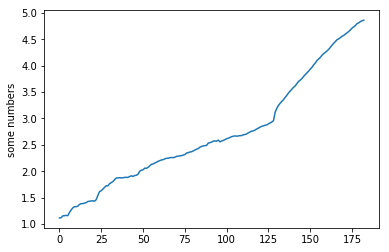

In [120]:
import matplotlib.pyplot as plt
plt.plot(outd_m)
plt.ylabel('some numbers')
plt.show()

In [77]:
# Hago un grafo mensual

for mes in meses:
    df_test = cran_mensual(df_ADJ,mes)
    DG = construir_grafo(df_test)
    nx.write_graphml_lxml(DG, "GRAPHS/" + mes + "_graph.graphml")